# model_7
# - training with selected VGG16 convolutional layers - final tuning
### - multi GPU processing

In [1]:
import numpy as np
import pandas as pd
import my_functions
import keras
from keras import layers
from keras import models
from keras import Model
from keras import optimizers
from keras.utils import multi_gpu_model
from keras.applications import VGG16
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.
/home/artur/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/artur/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/artur/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/artur/.local/lib/python3.6/site-packages/tensorflow/python/fra

## 1. New model configuration

#### - Not needed - already existing classifier + convolutional base from Keras

## 2. Data loading and transformation
- Available data:

In [2]:
%%bash
ls ./Used_data

TEST_IMAGES.npy
TEST_LABELS.npy
TRAIN_IMAGES.npy
TRAIN_LABELS.npy
TRAIN_X_EXTD.npy
TRAIN_Y_EXTD.npy
VALID_IMAGES.npy
VALID_LABELS.npy


In [3]:
# Loads and transforms 'Used data' to CNN training

train_x_name = 'TRAIN_X_EXTD.npy'
train_y_name = 'TRAIN_Y_EXTD.npy'

TRAIN_X, VALID_X, TEST_X, TRAIN_Y, VALID_Y, TEST_Y = my_functions.data_conversion(train_x_name, train_y_name)


LOADED DATA (before conversion):
  set name              shape  dtype       data sight
0  TRAIN_X  (8000, 96, 96, 3)  uint8     [87, 73, 37]
1  TRAIN_Y            (8000,)  uint8                2
2  VALID_X   (500, 96, 96, 3)  uint8  [204, 205, 210]
3  VALID_Y             (500,)  uint8                1
4   TEST_X   (500, 96, 96, 3)  uint8  [132, 167, 203]
5   TEST_Y             (500,)  uint8                1

DATA FOR TRAINING (after conversion):
  set name              shape    dtype                            data sight
0  TRAIN_X  (8000, 96, 96, 3)  float32  [0.34117648, 0.28627452, 0.14509805]
1  TRAIN_Y          (8000, 2)  float32                            [0.0, 1.0]
2  VALID_X   (500, 96, 96, 3)  float32           [0.8, 0.8039216, 0.8235294]
3  VALID_Y           (500, 2)  float32                            [1.0, 0.0]
4   TEST_X   (500, 96, 96, 3)  float32     [0.5176471, 0.654902, 0.79607844]
5   TEST_Y           (500, 2)  float32                            [1.0, 0.0]


## 3. model_7 - configuration and training
#### - Available layers overview:

In [4]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

### 3.1 Parallel_model, last vgg16 convolutional layer training & sgd optimizer

Model: "parallel model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vgg16_input (InputLayer)        (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 96, 96, 3)    0           vgg16_input[0][0]                
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 96, 96, 3)    0           vgg16_input[0][0]                
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 96, 96, 3)    0           vgg16_input[0][0]                
___________________________________________________________________________________

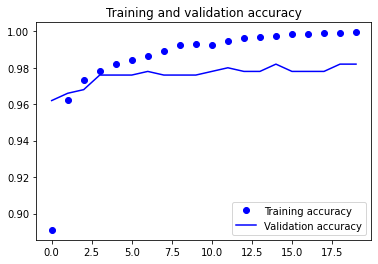

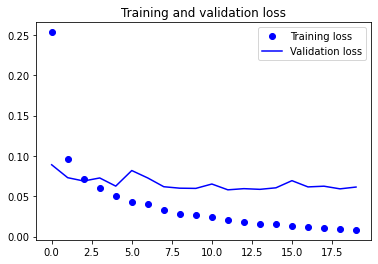

In [5]:
''' 
Instantiates the model.

Done with under a CPU device scope, so that the model's weights are hosted on CPU memory.
Otherwise they may end up hosted on a GPU, which would complicate weight sharing.
'''
with tf.device('/cpu:0'):
    
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    conv_base.trainable = True    # lockup of the trained weights  !!!

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv3':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    
    classifier_4 = keras.models.load_model('./Models/classifier_4.h5')  # not trained
  
    # Model aggregation:
    
    model_7 = models.Sequential()
    model_7.add(conv_base)
    model_7.add(layers.Flatten())
    model_7.add(classifier_4)
    
model = multi_gpu_model(model_7, gpus=3) # replication the model on 3 GPUs
model.name = 'parallel model_7'
model.summary()

epochs = 20
batch_size = 100
optimizer = 'sgd'
optimizer_name = optimizer
trd_model_name = 'model_7_8-100-20-1vgg16s-trd' # model after training, name without file extension !
notebook = 'Module_17'
model_descr = 'last vgg16 layer training'
dataset_size = len(TRAIN_X)

# Training (function no. 23)

acc = my_functions.train_and_chart(batch_size, epochs, model, optimizer, 
                                   TRAIN_X, TRAIN_Y, VALID_X, VALID_Y, trd_model_name)
del(model_7)
del(model)

In [6]:
remark = '3-overfit'

# Results saving (function no. 6)

my_functions.results_update(trd_model_name, model_descr, notebook, dataset_size, 
                            batch_size, epochs, optimizer_name, acc, remark)

# Results overview (function no. 8)

summary = pd.DataFrame(my_functions.results_preview()) 
summary.index = summary.index + 1
summary

,model_name,model_description,notebook,dataset_size,batch_size,epochs,optimizer,acc,remarks
1,model_0_0-100-150-sgd-trd,32-64-128-256-512,Module_1,1600,100,150,sgd,0.924,100-overfit
2,model_0_0-100-150-adlt-trd,32-64-128-256-512,Module_1,1600,100,150,adadelta,0.918,20-overfit
3,model_0_0-100-120-rmsp-trd,32-64-128-256-512,Module_1,1600,100,120,rmsprop,0.924,15-overfit
4,model_0_0-100-100-RMSp-trd,32-64-128-256-512,Module_1,1600,100,100,RMSprop(lr=1e-4),0.932,20-overfit
5,model_0_0-100-100-sgd-trd,32-64-128-256-512,Module_1,1600,100,100,sgd,0.904,no overfit
6,model_0_0-30-100-sgd-trd,32-64-128-256-512,Module_1,1600,30,100,sgd,0.918,40-overfit
7,model_0_0-15-40-sgd-trd,32-64-128-256-512,Module_1,1600,15,40,sgd,0.920,15-overfit
8,model_0_0-15-25-RMSp-trd,32-64-128-256-512,Module_1,1600,15,25,RMSprop(lr=1e-4),0.882,6-overfit
9,model_0_0-15-15-rmsp-trd,32-64-128-256-512,Module_1,1600,15,15,rmsprop,0.926,4-overfit
10,model_0_8-100-150-sgd-trd,32-64-128-256-512,Module_3,8000,100,150,sgd,0.522,80-overfit


### 3.2 Parallel_model, last vgg16 convolutional layer training & RMSprop(lr=1e-4)

Model: "parallel model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vgg16_input (InputLayer)        (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 96, 96, 3)    0           vgg16_input[0][0]                
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 96, 96, 3)    0           vgg16_input[0][0]                
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 96, 96, 3)    0           vgg16_input[0][0]                
___________________________________________________________________________________

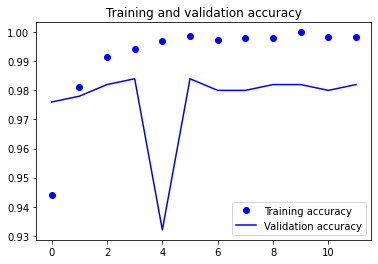

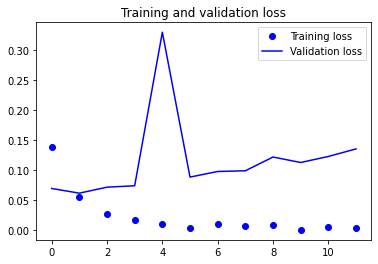

In [7]:
''' 
Instantiates the model.

Done with under a CPU device scope, so that the model's weights are hosted on CPU memory.
Otherwise they may end up hosted on a GPU, which would complicate weight sharing.
'''
with tf.device('/cpu:0'):
    
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    conv_base.trainable = True    # lockup of the trained weights  !!!

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv3':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    
    classifier_4 = keras.models.load_model('./Models/classifier_4.h5')  # not trained
  
    # Model aggregation:
    
    model_7 = models.Sequential()
    model_7.add(conv_base)
    model_7.add(layers.Flatten())
    model_7.add(classifier_4)
    
model = multi_gpu_model(model_7, gpus=3) # replication the model on 3 GPUs
model.name = 'parallel model_7'
model.summary()

epochs = 12
batch_size = 100
optimizer = optimizers.RMSprop(lr=1e-4)
optimizer_name = 'RMSprop(lr=1e-4)'
trd_model_name = 'model_7_8-100-12-1vgg16R-trd' # model after training, name without file extension !
notebook = 'Module_17'
model_descr = 'last vgg16 layer training'
dataset_size = len(TRAIN_X)

# Training (function no. 23)

acc = my_functions.train_and_chart(batch_size, epochs, model, optimizer, 
                                   TRAIN_X, TRAIN_Y, VALID_X, VALID_Y, trd_model_name)
del(model_7)
del(model)

In [8]:
remark = 'not ok'

# Results saving (function no. 6)

my_functions.results_update(trd_model_name, model_descr, notebook, dataset_size, 
                            batch_size, epochs, optimizer_name, acc, remark)

# Results overview (function no. 8)

summary = pd.DataFrame(my_functions.results_preview()) 
summary.index = summary.index + 1
summary

,model_name,model_description,notebook,dataset_size,batch_size,epochs,optimizer,acc,remarks
1,model_0_0-100-150-sgd-trd,32-64-128-256-512,Module_1,1600,100,150,sgd,0.924,100-overfit
2,model_0_0-100-150-adlt-trd,32-64-128-256-512,Module_1,1600,100,150,adadelta,0.918,20-overfit
3,model_0_0-100-120-rmsp-trd,32-64-128-256-512,Module_1,1600,100,120,rmsprop,0.924,15-overfit
4,model_0_0-100-100-RMSp-trd,32-64-128-256-512,Module_1,1600,100,100,RMSprop(lr=1e-4),0.932,20-overfit
5,model_0_0-100-100-sgd-trd,32-64-128-256-512,Module_1,1600,100,100,sgd,0.904,no overfit
6,model_0_0-30-100-sgd-trd,32-64-128-256-512,Module_1,1600,30,100,sgd,0.918,40-overfit
7,model_0_0-15-40-sgd-trd,32-64-128-256-512,Module_1,1600,15,40,sgd,0.920,15-overfit
8,model_0_0-15-25-RMSp-trd,32-64-128-256-512,Module_1,1600,15,25,RMSprop(lr=1e-4),0.882,6-overfit
9,model_0_0-15-15-rmsp-trd,32-64-128-256-512,Module_1,1600,15,15,rmsprop,0.926,4-overfit
10,model_0_8-100-150-sgd-trd,32-64-128-256-512,Module_3,8000,100,150,sgd,0.522,80-overfit


### 3.3 Parallel_model, last vgg16 convolutional layer training & sgd optimizer

Model: "parallel model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vgg16_input (InputLayer)        (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 96, 96, 3)    0           vgg16_input[0][0]                
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 96, 96, 3)    0           vgg16_input[0][0]                
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 96, 96, 3)    0           vgg16_input[0][0]                
___________________________________________________________________________________

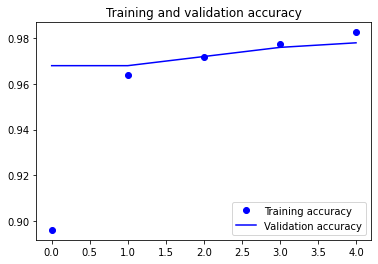

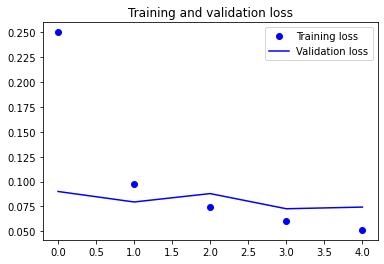

In [9]:
''' 
Instantiates the model.

Done with under a CPU device scope, so that the model's weights are hosted on CPU memory.
Otherwise they may end up hosted on a GPU, which would complicate weight sharing.
'''
with tf.device('/cpu:0'):
    
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    conv_base.trainable = True    # lockup of the trained weights  !!!

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv3':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    
    classifier_4 = keras.models.load_model('./Models/classifier_4.h5')  # not trained
  
    # Model aggregation:
    
    model_7 = models.Sequential()
    model_7.add(conv_base)
    model_7.add(layers.Flatten())
    model_7.add(classifier_4)
    
model = multi_gpu_model(model_7, gpus=3) # replication the model on 3 GPUs
model.name = 'parallel model_7'
model.summary()

epochs = 5
batch_size = 100
optimizer = 'sgd'
optimizer_name = optimizer
trd_model_name = 'model_7_8-100-5-1vgg16s-trd' # model after training, name without file extension !
notebook = 'Module_17'
model_descr = 'last vgg16 layer training'
dataset_size = len(TRAIN_X)

# Training (function no. 23)

acc = my_functions.train_and_chart(batch_size, epochs, model, optimizer, 
                                   TRAIN_X, TRAIN_Y, VALID_X, VALID_Y, trd_model_name)
del(model_7)
del(model)

In [10]:
remark = 'ok'

# Results saving (function no. 6)

my_functions.results_update(trd_model_name, model_descr, notebook, dataset_size, 
                            batch_size, epochs, optimizer_name, acc, remark)

# Results overview (function no. 8)

summary = pd.DataFrame(my_functions.results_preview()) 
summary.index = summary.index + 1
summary

,model_name,model_description,notebook,dataset_size,batch_size,epochs,optimizer,acc,remarks
1,model_0_0-100-150-sgd-trd,32-64-128-256-512,Module_1,1600,100,150,sgd,0.924,100-overfit
2,model_0_0-100-150-adlt-trd,32-64-128-256-512,Module_1,1600,100,150,adadelta,0.918,20-overfit
3,model_0_0-100-120-rmsp-trd,32-64-128-256-512,Module_1,1600,100,120,rmsprop,0.924,15-overfit
4,model_0_0-100-100-RMSp-trd,32-64-128-256-512,Module_1,1600,100,100,RMSprop(lr=1e-4),0.932,20-overfit
5,model_0_0-100-100-sgd-trd,32-64-128-256-512,Module_1,1600,100,100,sgd,0.904,no overfit
6,model_0_0-30-100-sgd-trd,32-64-128-256-512,Module_1,1600,30,100,sgd,0.918,40-overfit
7,model_0_0-15-40-sgd-trd,32-64-128-256-512,Module_1,1600,15,40,sgd,0.920,15-overfit
8,model_0_0-15-25-RMSp-trd,32-64-128-256-512,Module_1,1600,15,25,RMSprop(lr=1e-4),0.882,6-overfit
9,model_0_0-15-15-rmsp-trd,32-64-128-256-512,Module_1,1600,15,15,rmsprop,0.926,4-overfit
10,model_0_8-100-150-sgd-trd,32-64-128-256-512,Module_3,8000,100,150,sgd,0.522,80-overfit
